# Weather Image Classification using a Fusion of Deep & Machine Learning

This Kaggle notebook presents a comprehensive machine learning pipeline designed for Weather classification task. The pipeline integrates deep learning (DL) techniques with traditional machine learning algorithms to leverage the strengths of both approaches. We begin with feature extraction using a pre-trained Deep Learning model, followed by feature selection using Genetic Algorithm and classification using XGBoost.

## Pipeline Overview

The pipeline consists of the following key components:

1. **Fine-Tuning a pretrained deep learning model**: we fine-tune a pre-trained ResNet-101 keeping the fully connected classification layer.
   
2. **Find optimal XGBoost parameters**: we use a grid search approach to find the optimal parameters for XGBoost, this is done using the extracted features from the fine-tuned ResNet-101 model.
   
3. **Feature Selection**: we use a genetic algorithm to select the most relevant features from the extracted features, this is done using the extracted features from the fine-tuned ResNet-101 model and evaluated using the optimal XGBoost parameters.

4. **Performance Evaluation and Comparison**: Compares the performance of different models and stages of the pipeline using accuracy and F1-score metrics across training, validation, and test datasets.


### Library Imports 📚

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torchvision.io import read_image
import torchvision.transforms as transforms
import time
import copy
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3

  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### We Build this notebook on the [Weather Image Recognition Dataset](https://www.kaggle.com/datasets/jehanbhathena/weather-dataset) which consists of 6862 images of different weather conditions (11 Classes) listed below:

In [5]:
classes = ('dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow')

### Defining Custom Class to load the data from directories 📂

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_labels = []
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # Populate the img_labels list with tuples of image paths and labels
        for label_folder in os.listdir(img_dir):
            label_folder_path = os.path.join(img_dir, label_folder)
            if os.path.isdir(label_folder_path):
                for img_file in os.listdir(label_folder_path):
                    self.img_labels.append((os.path.join(label_folder, img_file), label_folder))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        full_img_path = os.path.join(self.img_dir, img_path)
        image = Image.open(full_img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        
        label = classes.index(label)
        label = torch.tensor(label)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label


### Creating Transform And Dataloaders 

In [7]:
# Define your transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),          # Resize the image to 256x256 pixels
    transforms.RandomHorizontalFlip(),      # Randomly flip the image horizontally
    transforms.RandomRotation(10),          # Randomly rotate the image by up to 10 degrees
    transforms.ToTensor(),                  # Convert the image to a PyTorch tensor
])


# Create the dataset
dataset = CustomImageDataset(img_dir='/kaggle/input/dataset', transform=transform)

train_size = int(0.7 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = int(0.2 * len(dataset))

trainset, testset,valset, _ = torch.utils.data.random_split(dataset, [train_size,test_size, val_size,  len(dataset)-train_size-test_size-val_size])



# Create a DataLoader
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)
valloader = DataLoader(valset, batch_size=32, shuffle=False)



### Visualizing random samples

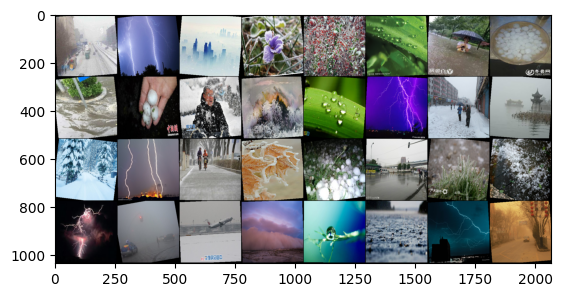

In [8]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))

### Visualization each class in the dataset

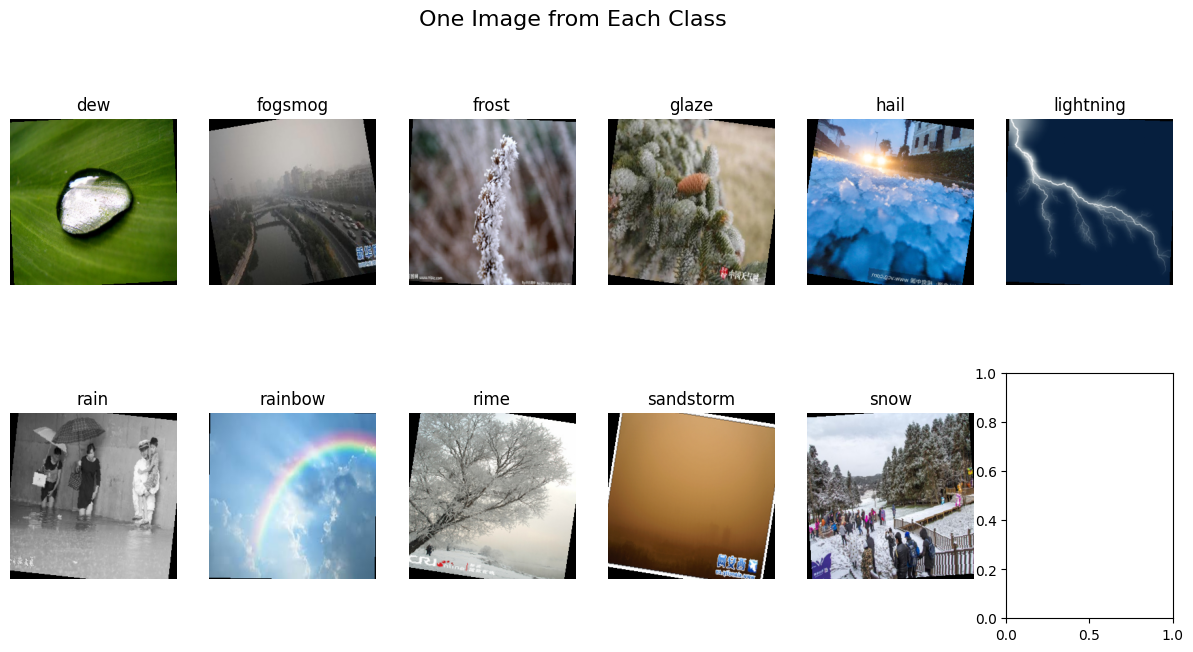

In [9]:
# Create a dictionary to store one image from each class
class_images = {class_name: None for class_name in classes}

# Find one image from each class
for data, target in dataset:
    if class_images[classes[target]] is None:
        class_images[classes[target]] = data
    if all(image is not None for image in class_images.values()):
        break

# Plot one image from each class
fig, axs = plt.subplots(2, 6, figsize=(15, 7))
fig.suptitle('One Image from Each Class', fontsize=16)

for i, (class_name, image) in enumerate(class_images.items()):
    row, col = divmod(i, 6)
    axs[row, col].imshow(np.transpose(image.numpy(), (1, 2, 0)))
    axs[row, col].set_title(class_name)
    axs[row, col].axis('off')

plt.show()

## Fine-Tuning a Pretrained Deep Learning Model

In the first stage of our pipeline, we use a pre-trained ResNet-101 model, which is a powerful deep learning model known for its effectiveness in image classification tasks. The key step here is fine-tuning, where we adjust the weights of the pre-trained model to better suit our specific task of weather image classification.

### Approach:
- **Pre-trained Model**: We start with ResNet-101, pre-trained on a ImageNet dataset. This model has already learned a rich set of image features that can be beneficial for our task.
- **Fine-Tuning**: The model is then fine-tuned on our weather image dataset using Cross-Entropy loss and Adam optimizer. The model is trained for 10 epochs with an initial learning rate of 0.001.
- **Classification Layer**: Initially The original classification layer of ResNet-101 is kept to perform fine-tuning and generate baseline performance reports, which we will later remove to use the model as a feature extractor.


In [10]:
# 1. Modify ResNet Model for Fine-Tuning
class ResNetFineTuner(nn.Module):
    def __init__(self, num_classes):
        super(ResNetFineTuner, self).__init__()
        # Load the pretrained ResNet model
        self.resnet = models.resnet101(weights='ResNet101_Weights.IMAGENET1K_V1')
        # Replace the last fully connected layer with a new one
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [11]:
# Initialize the fine-tuner
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 11
fine_tuner = ResNetFineTuner(num_classes).to(device)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth

100%|██████████| 171M/171M [00:00<00:00, 283MB/s]


#### Defining the training funciton

In [12]:
def fine_tune_model(model, train_loader, val_loader, model_save_path,learning_rate=0.01, num_epochs=10, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience//2, verbose=True)

    # Early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_stats = -1

    # Lists to store metrics
    train_accuracies = []
    train_f1_scores = []
    train_losses = []
    val_accuracies = []
    val_f1_scores = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        total_e_loss = 0
        num_batches = 0
        model.train()  # Set model to training mode
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_e_loss = loss.item() + total_e_loss
            num_batches = num_batches + 1
            loss.backward()
            optimizer.step()
        
        e_loss = total_e_loss / num_batches
        train_losses.append(e_loss)
        # Evaluation
        model.eval()  # Set model to evaluation mode
        train_labels = []
        train_preds = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_accuracy = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')

        # Evaluation on validation data
        val_loss = 0
        val_labels = []
        val_preds = []
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        train_f1_scores.append(train_f1)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        
        ##
        clear_output()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {e_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, Validation F1: {val_f1:.4f}')
        
        # Learning rate scheduler step
        scheduler.step(val_loss)
        # Check early stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_stats = [train_accuracy, train_f1, val_accuracy, val_f1]
            torch.save(model.state_dict(), model_save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                break
                
        # Plotting
        epochs_range = range(1, epoch + 2)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
        plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs_range, train_f1_scores, label='Training F1 Score')
        plt.plot(epochs_range, val_f1_scores, label='Validation F1 Score')
        plt.title('Training and Validation F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        
        plt.subplot(1, 3, 3)
        plt.plot(epochs_range, train_losses, label='Training Loss')
        plt.plot(epochs_range, val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Cross Entropy Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()
        
    return best_model_stats


Epoch [10/10], Loss: 0.4060, Train Accuracy: 0.7797, Train F1: 0.7810, Validation Accuracy: 0.7340, Validation F1: 0.7360

Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.


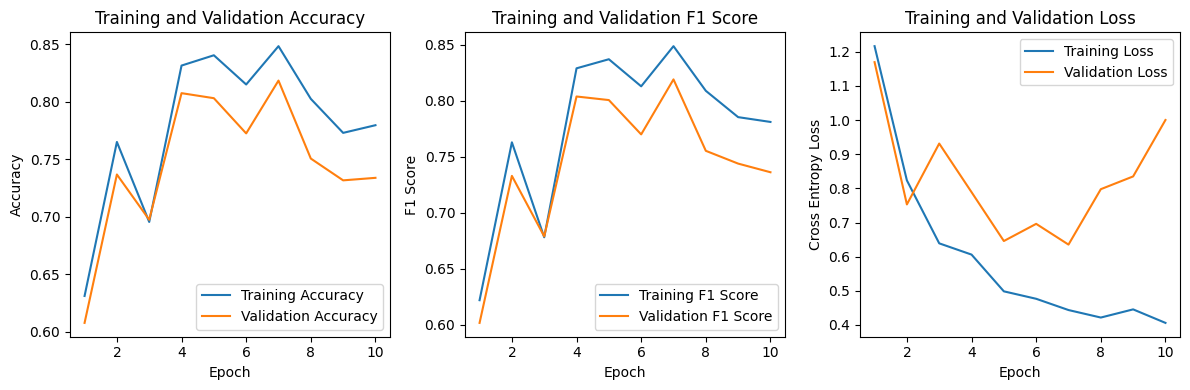

100%|██████████| 10/10 [19:02<00:00, 114.30s/it]


In [13]:
# Fine-tune the model
learning_rate = 0.001
num_epochs = 10
patience=5
model_save_path = 'model.pth'
best_model_stats = fine_tune_model(fine_tuner, trainloader, valloader, learning_rate=learning_rate,
                num_epochs=num_epochs, patience=patience, model_save_path=model_save_path)

In [14]:
def get_labels(dataloader):
    labelsl = []
    for _, labels in dataloader:
        labelsl.extend(labels.cpu().detach().numpy())
        
    return labelsl

In [15]:
trainloader = DataLoader(trainset, batch_size=32, shuffle=False)

labels = get_labels(trainloader)
labels_val = get_labels(valloader)
labels_test = get_labels(testloader)

In [16]:
def get_model_predictions(model, dataloader):
    model.eval()  # Set the model to evaluation mode

    predictions = []
    with torch.no_grad():  # No need to track gradients
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions


In [17]:
def generate_accuracy_report(ground_truth, predictions):
    report = classification_report(ground_truth, predictions, digits=4)
    return report

In [18]:
## load best model state
# Load the state dictionary
state_dict = torch.load(model_save_path)
print('Loaded Model With Stats', best_model_stats)
# Update the model's state dictionary
fine_tuner.load_state_dict(state_dict)

Loaded Model With Stats [0.8484280657922132, 0.848652711022735, 0.8185131195335277, 0.8189728110020215]


<All keys matched successfully>

### Generating the baseline performance report 📊

In [19]:
train_preds_p1 = get_model_predictions(fine_tuner, trainloader)
cross_val_preds_p1 = get_model_predictions(fine_tuner, valloader)
test_preds_p1 = get_model_predictions(fine_tuner, testloader)


# Evaluate on train data
train_report_p1 = generate_accuracy_report(labels, train_preds_p1)
print("Train Data Classification Report:\n", train_report_p1)

# Evaluate on cross-validation data
cross_val_report_p1 = generate_accuracy_report(labels_val, cross_val_preds_p1)
print("Cross-validation Data Classification Report:\n", cross_val_report_p1)

# Evaluate on test data
test_report_p1 = generate_accuracy_report(labels_test, test_preds_p1)
print("Test Data Classification Report:\n", test_report_p1)

Train Data Classification Report:

               precision    recall  f1-score   support



           0     0.9248    0.9770    0.9502       478

           1     0.9485    0.8746    0.9101       590

           2     0.8889    0.6467    0.7487       334

           3     0.7581    0.7263    0.7418       453

           4     0.8160    0.9691    0.8860       421

           5     0.9609    1.0000    0.9801       246

           6     0.9317    0.8197    0.8721       366

           7     0.9706    0.9821    0.9763       168

           8     0.9002    0.7265    0.8041       819

           9     0.8857    0.9548    0.9190       487

          10     0.5832    0.8503    0.6919       441



    accuracy                         0.8499      4803

   macro avg     0.8699    0.8661    0.8618      4803

weighted avg     0.8644    0.8499    0.8507      4803



Cross-validation Data Classification Report:

               precision    recall  f1-score   support



           0     0.8503    0.

In [20]:
# 2. Feature Extraction (after fine-tuning)
# Remove the last fully connected layer
fine_tuner.resnet.fc = nn.Identity()

In [21]:
def extract_features(dataloader, model):
    features = []
    for inputs, _ in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        # Flatten the output features
        outputs = outputs.view(outputs.size(0), -1)
        features.append(outputs.cpu().detach().numpy())
    return np.concatenate(features, axis=0)

In [22]:
# Extract features
train_features = extract_features(trainloader, fine_tuner)
cross_features = extract_features(valloader, fine_tuner)
test_features = extract_features(testloader, fine_tuner)

In [23]:
# Encode labels if they are not already in the format 0, 1, 2, ...
label_encoder = LabelEncoder()
label_encoder.fit(labels)
encoded_labels = np.array(label_encoder.transform(labels))
encoded_labels_val = np.array(label_encoder.transform(labels_val))
encoded_labels_test = np.array(label_encoder.transform(labels_test))

## Find Optimal XGBoost Parameters

After feature extraction with ResNet-101, we employ XGBoost, a highly efficient and scalable gradient boosting framework, to classify the images. The key to maximizing the performance of XGBoost is finding the optimal set of hyperparameters.

### Approach:
- **Grid Search**: We employ grid search, an exhaustive search over a specified parameter space, to find the best combination of parameters for our XGBoost model.
- **Evaluation Metric**: The performance of each parameter combination is evaluated using metrics such as accuracy and F1-score.
- **Parameter Space**: Parameters like `max_depth`, `learning_rate`, and `n_estimators` are varied to explore a wide range of models.

This stage is crucial for ensuring that the XGBoost model performs at its best, taking full advantage of the features extracted from the images, this is also important because the the optimal xgb model found will used a classifier for the fitness function in the genetic algorithm later in the pipeline.


In [24]:
# Define the parameter grid,.. to-do : add more parameters
param_grid = {
    'max_depth': [3,10],
    'learning_rate': [0.1],
    'n_estimators': [2000, 5000],
    'reg_lambda': [1,2],  
    
}

# Create a xgb model
model = xgb.XGBClassifier(device="cuda", objective='multi:softmax', num_class=11)

# Set up GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_weighted', verbose=1)

# Fit the grid search to the data
grid_search.fit(train_features, encoded_labels)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:17:12] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.

Potential solutions:

- Use a data structure that matches the device ordinal in the booster.

- Set the device for booster before call to inplace_predict.



This warning will only be shown once.



  warnings.warn(smsg, UserWarning)


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 5000, 'reg_lambda': 1}

Best accuracy found:  0.904437151002683


In [25]:
def evaluate_model(classifier, features, true_labels):
    predictions = classifier.predict(features)
    return classification_report(true_labels, predictions, digits=4), predictions

In [26]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 5000, 'reg_lambda': 1}

### Establishing baseline performance for the genetic algorithm

In [27]:
model = xgb.XGBClassifier(device="cuda", objective='multi:softmax', num_class=11, **grid_search.best_params_)
model.fit(train_features, encoded_labels)

# Evaluate on train data
train_report_p2, train_preds_p2 = evaluate_model(model, train_features, encoded_labels)
print("Train Data Classification Report:\n", train_report_p2)

# Evaluate on cross-validation data
cross_val_report_p2, cross_val_preds_p2 = evaluate_model(model, cross_features, encoded_labels_val)
print("Cross-validation Data Classification Report:\n", cross_val_report_p2)

# Evaluate on test data
test_report_p2,test_preds_p2  = evaluate_model(model, test_features, encoded_labels_test)
print("Test Data Classification Report:\n", test_report_p2)

Train Data Classification Report:

               precision    recall  f1-score   support



           0     1.0000    1.0000    1.0000       478

           1     1.0000    1.0000    1.0000       590

           2     1.0000    1.0000    1.0000       334

           3     1.0000    1.0000    1.0000       453

           4     1.0000    1.0000    1.0000       421

           5     1.0000    1.0000    1.0000       246

           6     1.0000    1.0000    1.0000       366

           7     1.0000    1.0000    1.0000       168

           8     1.0000    1.0000    1.0000       819

           9     1.0000    1.0000    1.0000       487

          10     1.0000    1.0000    1.0000       441



    accuracy                         1.0000      4803

   macro avg     1.0000    1.0000    1.0000      4803

weighted avg     1.0000    1.0000    1.0000      4803



Cross-validation Data Classification Report:

               precision    recall  f1-score   support



           0     0.9191    0.

## Feature Selection with Genetic Algorithm

Feature selection is a critical step in our pipeline, aiming to reduce the dimensionality of the feature space and improve model performance. We employ a genetic algorithm for this purpose, an evolutionary approach that mimics the process of natural selection.

### Approach:
- **Genetic Algorithm**: This algorithm iteratively selects, breeds, and mutates a population of feature sets to find the most effective subset of features.
- **Fitness Function**: The effectiveness of each feature set is evaluated using the XGBoost model with optimal parameters. The fitness function is usually defined in terms of F1-score on the validation set.
- **Evolutionary Process**: Over several generations, the algorithm converges on a set of features that provide the best performance for our XGBoost model.

This method allows us to intelligently reduce the number of features, focusing on those most relevant for distinguishing different weather conditions.

In [28]:
class GeneticMutationOptimizer:
    def __init__(self, population_size=50, mutation_rate=0.005, crossover_rate=0.5, num_generations=5, num_features=2048):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.num_generations = num_generations
        self.num_features = num_features

    def initialize_population(self):
#         return np.random.randint(2, size=(self.population_size, self.num_features))
        return np.ones((self.population_size, self.num_features))
    
    def fitness(self, individual, features, labels, model, features_val, labels_val):
        # Extract the features based on the individual's gene
        selected_features = features[:, individual == 1]
        selected_features_val = features_val[:, individual == 1]
#         print(f"selecting {selected_features.shape[1]} features")
        # Train and evaluate the model using these features
        model.fit(selected_features, labels)
        predictions = model.predict(selected_features_val)
        f1_weighted_score = f1_score(labels_val, predictions, average='weighted')

        return f1_weighted_score

    def select(self, population, fitness_scores):
        # Perform selection based on fitness scores
        parents = np.random.choice(np.arange(self.population_size), size=self.population_size, replace=True, p=fitness_scores/fitness_scores.sum())
        return population[parents]

    def crossover(self, parent1, parent2):
        if np.random.rand() < self.crossover_rate:
            crossover_point = np.random.randint(1, self.num_features)
            child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        else:
            child = parent1.copy()
        return child

    def mutate(self, individual):
        for i in range(self.num_features):
            if np.random.rand() < self.mutation_rate:
                individual[i] = 1 - individual[i]
        return individual

    def optimize(self, features, labels, model, features_val, labels_val):
        population = self.initialize_population()
        best_individual = None
        best_fitness = 0

        for generation in tqdm(range(self.num_generations)):
            fitness_scores = np.array([self.fitness(individual, features, labels, model, features_val, labels_val) for individual in population])
            best_generation_fitness = np.max(fitness_scores)
            if best_generation_fitness > best_fitness:
                best_fitness = best_generation_fitness
                best_individual = population[np.argmax(fitness_scores)].copy()
            
            print("best fitness so far", best_fitness)
            
            selected = self.select(population, fitness_scores)
            population = np.array([self.crossover(selected[np.random.randint(self.population_size)], selected[np.random.randint(self.population_size)]) for _ in range(self.population_size)])
            population = np.array([self.mutate(individual) for individual in population])

        return best_individual

In [29]:
# classifier = svm.SVC()
classifier = xgb.XGBClassifier(**grid_search.best_params_,device="cuda", objective='multi:softmax', num_class=11)
# classifier = KNeighborsClassifier(n_neighbors=4)

genetic_optimizer = GeneticMutationOptimizer(num_features=2048)
selected_features_idx = genetic_optimizer.optimize(train_features, encoded_labels, classifier, cross_features, encoded_labels_val)

 20%|██        | 1/5 [1:05:30<4:22:00, 3930.04s/it]

best fitness so far 0.8747589581284199


 40%|████      | 2/5 [2:10:37<3:15:50, 3916.85s/it]

best fitness so far 0.8807678659912589


 60%|██████    | 3/5 [3:15:31<2:10:12, 3906.31s/it]

best fitness so far 0.8807678659912589


 80%|████████  | 4/5 [4:20:12<1:04:56, 3896.21s/it]

best fitness so far 0.8807678659912589


100%|██████████| 5/5 [5:24:36<00:00, 3895.33s/it]

best fitness so far 0.8807678659912589


Printing the Amount of Selected Features

In [30]:
len(selected_features_idx[selected_features_idx == 1])

2040

In [31]:
# Select features based on the indices from the optimizer
selected_train_features = train_features[:, selected_features_idx==1]
selected_cross_features = cross_features[:, selected_features_idx==1]
selected_test_features = test_features[:, selected_features_idx==1]

### Finally we fit the optimal xgb model with the selected features and evaluate the performance

In [32]:
# Train the classifier
classifier.fit(selected_train_features, encoded_labels)

# Evaluate on train data
train_report_p3, train_preds_p3 = evaluate_model(classifier, selected_train_features, encoded_labels)
print("Train Data Classification Report:\n", train_report_p3)

# Evaluate on cross-validation data
cross_val_report_p3, cross_val_preds_p3 = evaluate_model(classifier, selected_cross_features, encoded_labels_val)
print("Cross-validation Data Classification Report:\n", cross_val_report_p3)

# Evaluate on test data
test_report_p3, test_preds_p3 = evaluate_model(classifier, selected_test_features, encoded_labels_test)
print("Test Data Classification Report:\n", test_report_p3)


Train Data Classification Report:

               precision    recall  f1-score   support



           0     1.0000    1.0000    1.0000       478

           1     1.0000    1.0000    1.0000       590

           2     1.0000    1.0000    1.0000       334

           3     1.0000    1.0000    1.0000       453

           4     1.0000    1.0000    1.0000       421

           5     1.0000    1.0000    1.0000       246

           6     1.0000    1.0000    1.0000       366

           7     1.0000    1.0000    1.0000       168

           8     1.0000    1.0000    1.0000       819

           9     1.0000    1.0000    1.0000       487

          10     1.0000    1.0000    1.0000       441



    accuracy                         1.0000      4803

   macro avg     1.0000    1.0000    1.0000      4803

weighted avg     1.0000    1.0000    1.0000      4803



Cross-validation Data Classification Report:

               precision    recall  f1-score   support



           0     0.9185    0.

## Performance Evaluation and Comparison

Finally, we thoroughly evaluate and compare the performance of our pipeline at different stages using various metrics.

### Approach:
- **Metrics**: Key metrics for evaluation include accuracy and F1-score. We calculate these metrics for each stage of the pipeline - post fine-tuning, after xgb hyperparameter optimization, and following feature selection.
- **Datasets**: Performance is assessed across different datasets: training, validation, and testing. This helps in understanding the model's ability to generalize.
- **Comparative Analysis**: We visualize the performance metrics to compare how each stage of the pipeline contributes to the overall effectiveness of the model.

Through this comprehensive evaluation, we can understand the strengths and weaknesses of our pipeline and make informed decisions about potential improvements or adjustments.

In [33]:
from sklearn.metrics import accuracy_score, f1_score

def calculate_metrics(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    f1_weighted = f1_score(true_labels, predictions, average='weighted')
    return accuracy, f1_weighted

# Assuming you have the true labels as encoded_labels, encoded_labels_val, encoded_labels_test
# Calculate metrics for train data
train_accuracy_p1, train_f1_weighted_p1 = calculate_metrics(encoded_labels, train_preds_p1)
train_accuracy_p2, train_f1_weighted_p2 = calculate_metrics(encoded_labels, train_preds_p2)
train_accuracy_p3, train_f1_weighted_p3 = calculate_metrics(encoded_labels, train_preds_p3)

# Calculate metrics for cross-validation data
cross_val_accuracy_p1, cross_val_f1_weighted_p1 = calculate_metrics(encoded_labels_val, cross_val_preds_p1)
cross_val_accuracy_p2, cross_val_f1_weighted_p2 = calculate_metrics(encoded_labels_val, cross_val_preds_p2)
cross_val_accuracy_p3, cross_val_f1_weighted_p3 = calculate_metrics(encoded_labels_val, cross_val_preds_p3)

# Calculate metrics for test data
test_accuracy_p1, test_f1_weighted_p1 = calculate_metrics(encoded_labels_test, test_preds_p1)
test_accuracy_p2, test_f1_weighted_p2 = calculate_metrics(encoded_labels_test, test_preds_p2)
test_accuracy_p3, test_f1_weighted_p3 = calculate_metrics(encoded_labels_test, test_preds_p3)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

  order = pd.unique(vector)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

  order = pd.unique(vector)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

  order = pd.unique(vector)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

  order = pd.unique(vector)

/opt/conda/lib/pytho

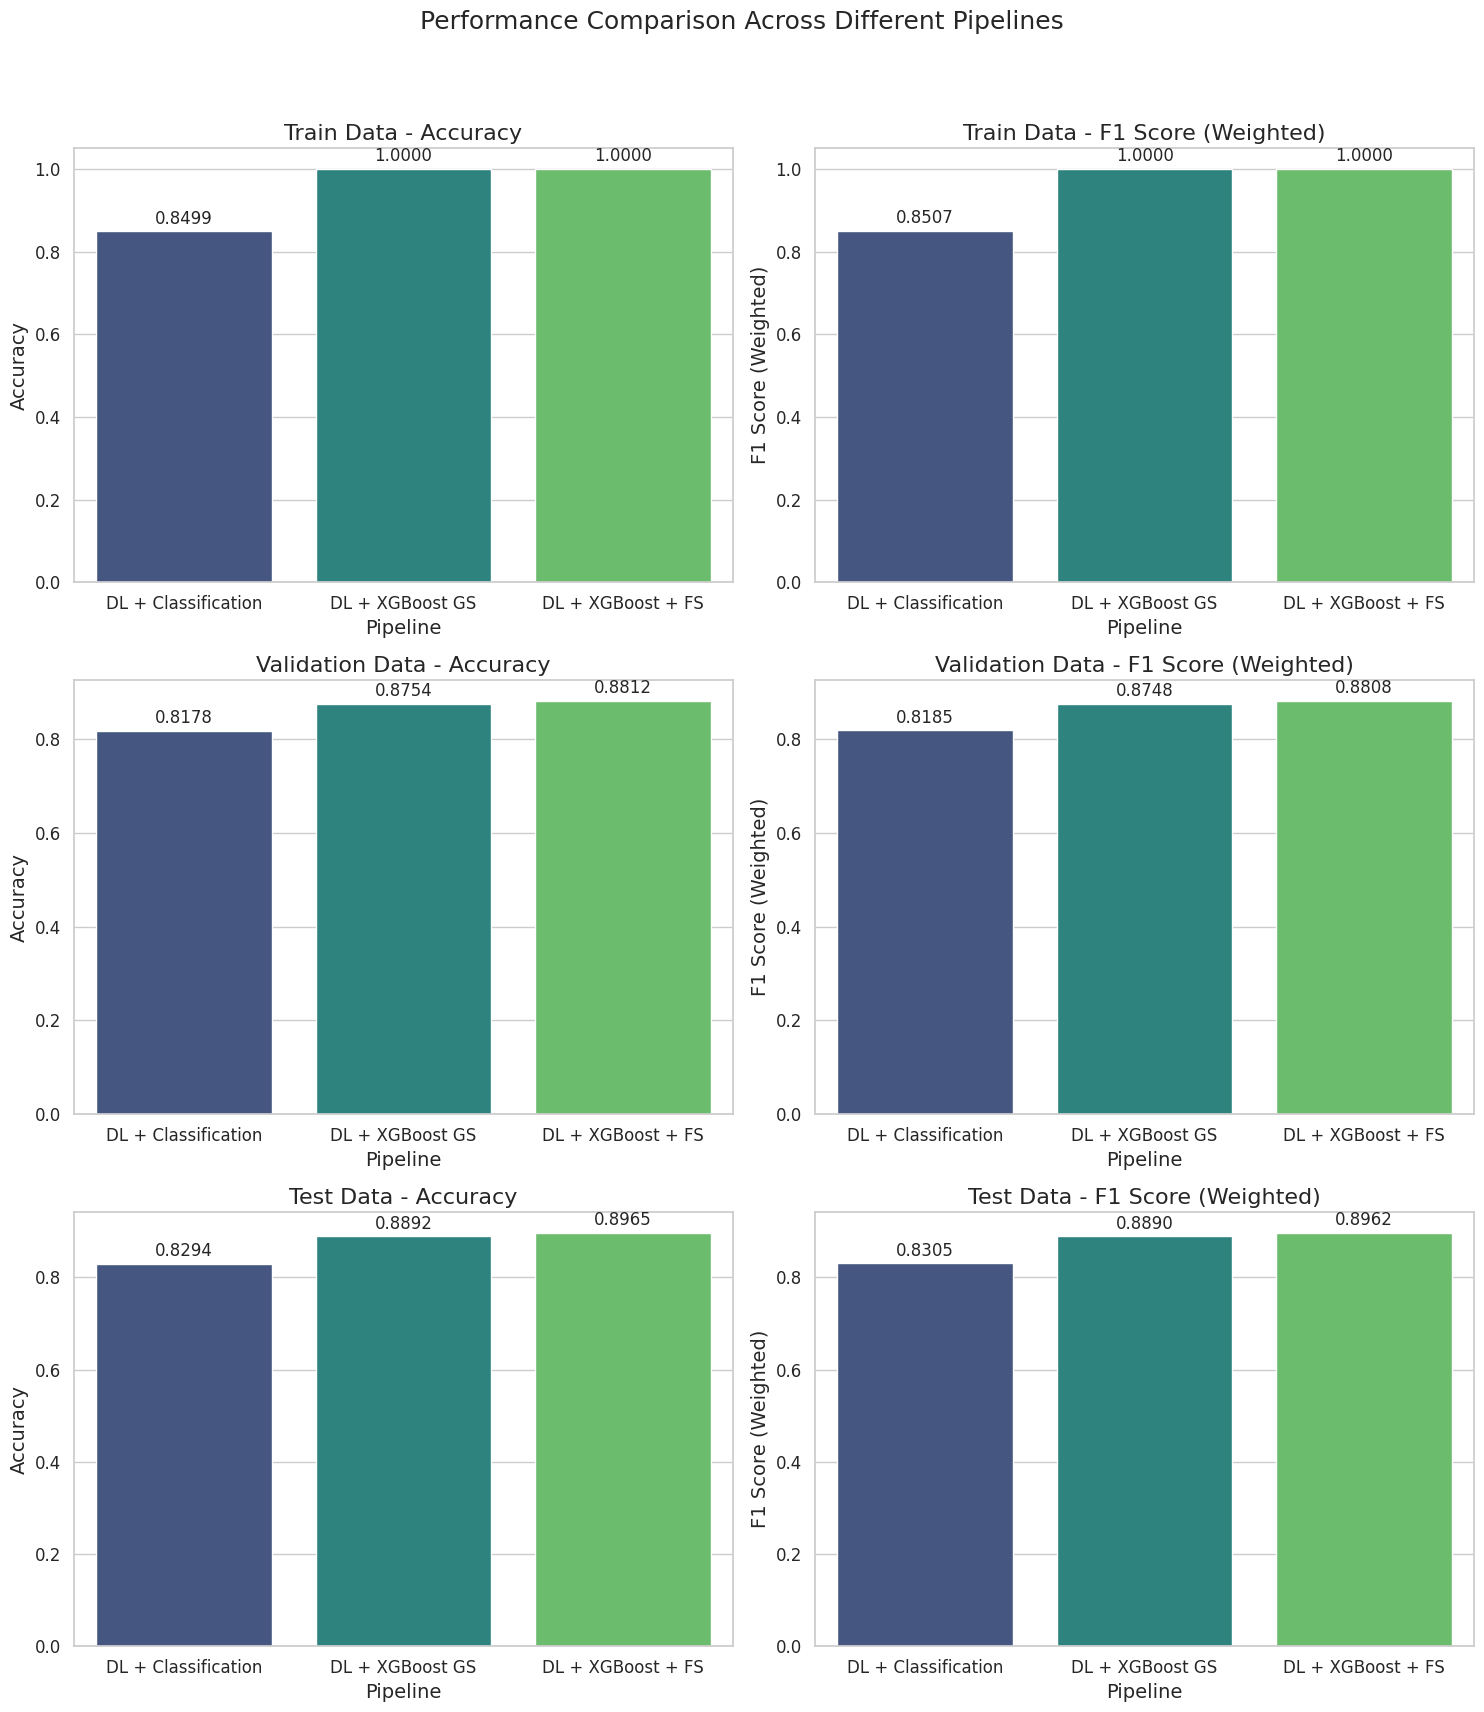

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the aesthetics for Seaborn
sns.set_theme(style="whitegrid")

# Data for plotting
pipelines = ['DL + Classification', 'DL + XGBoost GS', 'DL + XGBoost + FS']
# Accuracy and F1-scores for each pipeline and dataset
train_accuracies = [train_accuracy_p1, train_accuracy_p2, train_accuracy_p3]
train_f1_scores = [train_f1_weighted_p1, train_f1_weighted_p2, train_f1_weighted_p3]
cross_val_accuracies = [cross_val_accuracy_p1, cross_val_accuracy_p2, cross_val_accuracy_p3]
cross_val_f1_scores = [cross_val_f1_weighted_p1, cross_val_f1_weighted_p2, cross_val_f1_weighted_p3]
test_accuracies = [test_accuracy_p1, test_accuracy_p2, test_accuracy_p3]
test_f1_scores = [test_f1_weighted_p1, test_f1_weighted_p2, test_f1_weighted_p3]

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('Performance Comparison Across Different Pipelines', fontsize=18)

def plot_bar(ax, metric_values, title, metric_name):
    """Plots a bar chart on the given axes."""
    sns.barplot(x=pipelines, y=metric_values, palette="viridis", ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric_name, fontsize=14)
    ax.set_xlabel('Pipeline', fontsize=14)
    ax.tick_params(labelsize=12)
    # Add the metric values on top of the bars
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

# Plotting for each subplot
plot_bar(axes[0, 0], train_accuracies, 'Train Data - Accuracy', 'Accuracy')
plot_bar(axes[0, 1], train_f1_scores, 'Train Data - F1 Score (Weighted)', 'F1 Score (Weighted)')
plot_bar(axes[1, 0], cross_val_accuracies, 'Validation Data - Accuracy', 'Accuracy')
plot_bar(axes[1, 1], cross_val_f1_scores, 'Validation Data - F1 Score (Weighted)', 'F1 Score (Weighted)')
plot_bar(axes[2, 0], test_accuracies, 'Test Data - Accuracy', 'Accuracy')
plot_bar(axes[2, 1], test_f1_scores, 'Test Data - F1 Score (Weighted)', 'F1 Score (Weighted)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
plt.show()
